In [1]:
from matplotlib import gridspec
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import seaborn as sns

In [2]:
btc_raw = pd.read_csv("BTC-USD.csv", index_col=0, parse_dates=True, dayfirst=True)

In [3]:
btc_raw['Returns'] = np.log(btc_raw['Adj Close'].astype(np.float)/btc_raw['Adj Close'].shift(1).astype(float))

In [4]:
btc_raw = btc_raw[datetime(2018,1,1):datetime(2019,7,13)]

In [5]:
btc_raw_insample = btc_raw[datetime(2018,1,1):datetime(2018,12,31)]

In [6]:
btc_raw_outsample = btc_raw[datetime(2019,1,1):datetime(2019,7,13)]

In [7]:
btc_raw = btc_raw_insample[1:]

In [8]:
eth_raw = pd.read_csv("ETH-USD.csv", index_col=0, parse_dates=True, dayfirst=True)

In [9]:
eth_raw['Returns'] = np.log(eth_raw['Adj Close'].astype(np.float)/eth_raw['Adj Close'].shift(1).astype(float))

In [10]:
eth_raw = eth_raw[datetime(2018,1,1):datetime(2019,7,13)]

In [11]:
eth_raw_outsample = eth_raw[datetime(2019,1,1):datetime(2019,7,13)]

In [12]:
eth_raw_insample = eth_raw[datetime(2018,1,1):datetime(2018,12,31)]

In [13]:
eth_raw = eth_raw_insample[1:]

In [14]:
returns1 = btc_raw['Returns'].values

In [15]:
returns2 = eth_raw['Returns'].values

In [16]:
Y1_t = btc_raw['Adj Close']

In [17]:
Y2_t = eth_raw['Adj Close']

In [18]:
Y1_t_Series = pd.Series(Y1_t, name='Bitcoin')

In [19]:
Y2_t_Series = pd.Series(Y2_t, name='Ethereum')

In [20]:
returns1_os = btc_raw_outsample['Returns'].values

In [21]:
returns2_os = eth_raw_outsample['Returns'].values

In [22]:
Y1_t_os = btc_raw_outsample['Adj Close']

In [23]:
Y2_t_os = eth_raw_outsample['Adj Close']

In [24]:
Y1_t_Series_os = pd.Series(Y1_t_os, name='Bitcoin')

In [25]:
Y2_t_Series_os = pd.Series(Y2_t_os, name='Ethereum')

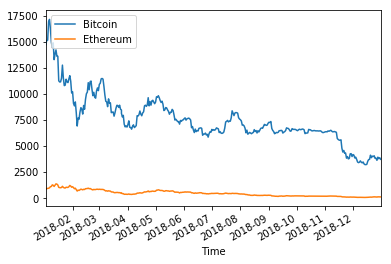

In [26]:
_ = Y1_t_Series.plot()
_ = Y2_t_Series.plot()
_ = plt.xlabel('Time')
_ = plt.legend(['Bitcoin', 'Ethereum'], loc='upper left')

In [27]:
dY1_t = pd.Series(Y1_t, name='Δ Bitcoin').diff().dropna()

In [28]:
dY2_t = pd.Series(Y2_t, name='Δ Ethereum').diff().dropna()

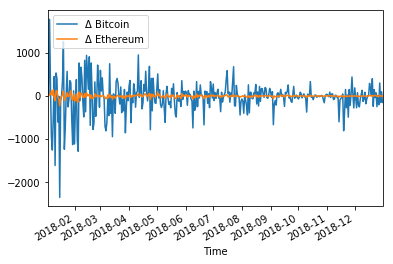

In [29]:
_ = dY1_t.plot()
_ = dY2_t.plot()
_ = plt.xlabel('Time')
_ = plt.legend(['Δ Bitcoin', 'Δ Ethereum'], loc='upper left')

In [30]:
print('Loading all VAR/OLS/Optimal Lag functions')
%run Cointegration.py
print('Additional functions loaded')

Loading all VAR/OLS/Optimal Lag functions
Additional functions loaded


In [31]:
data = pd.concat([btc_raw['Returns'], eth_raw['Returns']], axis = 1, keys = ['Bitcoin Returns', 'Ethereum Returns'])

In [32]:
Yt = np.vstack((Y1_t, Y2_t))

In [33]:
Yr = np.vstack((returns1, returns2))

In [34]:
dY = np.vstack((dY1_t, dY2_t))

In [35]:
maxlags = int(round(12*(len(Yr)/100.)**(1/4)))

In [36]:
print('Maxlags to test: %d' % maxlags)

Maxlags to test: 5


In [37]:
maxlagOptimumVectorAR = GetOptimalLag(Yr, maxlags, modelType='VectorAR')

In [38]:
print(maxlagOptimumVectorAR)

{'aicbest': -13.12946529404962, 'bestlagaic': 5, 'bicbest': -13.064960086923522, 'bestlagbic': 0}


In [39]:
model = VAR(Yr.T)

In [40]:
results = model.fit(maxlags, method='ols', ic='aic', trend='c', verbose=True)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 0, BIC -> 0, FPE -> 0, HQIC -> 0>
Using 0 based on aic criterion


In [41]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Jul, 2019
Time:                     12:14:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.0650
Nobs:                     364.000    HQIC:                  -13.0779
Log likelihood:           1350.73    FPE:                2.07329e-06
AIC:                     -13.0864    Det(Omega_mle):     2.06195e-06
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.003510         0.002301           -1.525           0.127

Results for equation y2
           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------

In [42]:
# Stability Check
resultGetADFuller = GetADFuller(Y=dY1_t, maxlags = 0, regression='c')
roots = resultGetADFuller['roots']
IsStable(roots)

False

In [43]:
# Result from custom implementation

print("ADF Statistic: %f" % resultGetADFuller['adfstat'])

ADF Statistic: -19.456825


In [44]:
# Verify result from statsmodel implementation

resultadfuller = adfuller(dY1_t, maxlag=0, regression='c', autolag=None, regresults=True)
print(resultadfuller)

(-19.45682509622128, 0.0, {'1%': -3.448544133483233, '5%': -2.8695574079525565, '10%': -2.5710411593052713}, <statsmodels.tsa.stattools.ResultsStore object at 0x0000022C32148198>)


In [45]:
# Engle-Granger Self Implementation

Y2_t_d = np.vstack((np.ones(len(Y2_t)), Y2_t))
resultGetOLS = GetOLS(Y=Y1_t.values, X=Y2_t_d)

a_hat = resultGetOLS['beta_hat'][0,0]
beta2_hat = resultGetOLS['beta_hat'][0,1]

et_hat = Y1_t - np.dot(beta2_hat, Y2_t) - a_hat

result_et_hat_adf = GetADFuller(Y=et_hat, maxlags=1, regression='nc')
print('ADF Statistic: %f' % result_et_hat_adf['adfstat'])

ADF Statistic: -4.243614


In [46]:
# Verifying above with statsmodel

sm_result_et_hat_adf = adfuller(et_hat, maxlag=1, regression='nc', autolag=None, regresults=True)
print(sm_result_et_hat_adf)

resultols = OLS(Y1_t.T, Y2_t_d.T).fit()

resultols.summary2()

(-4.243614319828544, 2.7517143775264966e-05, {'1%': -2.5719439208204875, '5%': -1.9417670091619517, '10%': -1.616106474265908}, <statsmodels.tsa.stattools.ResultsStore object at 0x0000022C32148E48>)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.806     
Dependent Variable: Adj Close        AIC:                6105.7116 
Date:               2019-07-18 12:14 BIC:                6113.5059 
No. Observations:   364              Log-Likelihood:     -3050.9   
Df Model:           1                F-statistic:        1507.     
Df Residuals:       362              Prob (F-statistic): 4.20e-131 
R-squared:          0.806            Scale:              1.1219e+06
--------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const     4042.6780  105.6144  38.2777  0.0000  3834.9831  4250.3729
x1           7.2587    0.1870  38.8233  0.0000     6.8911     7.6264
-------------------------------------------------------------------
Omnibus:              130.038       Durbin-Watson:          0.059  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       693.657
Skew:                 1.413         Prob(JB):               0.000  
Kurtosis:             9.144         Condition No.:          1075   
===================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

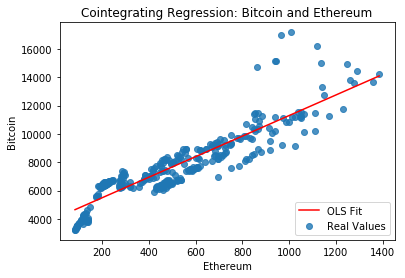

In [47]:
# Plot OLS Fit

# Generate equally spaced X values between the true X range
x_axis = np.linspace(Y2_t.min(), Y2_t.max(), 100)

#Plot the estimated dependent variable
Y1_t_hat = a_hat + beta2_hat * x_axis

# Plot own fit on top of seaborrn scatter + fit
plt.title('Cointegrating Regression: Bitcoin and Ethereum')
ax = sns.regplot(x=Y2_t_Series, y=Y1_t_Series, fit_reg=False)
ax.plot(x_axis, Y1_t_hat, 'r')
plt.legend(['OLS Fit', 'Real Values'], loc='lower right')

Text(0.5, 0, '')

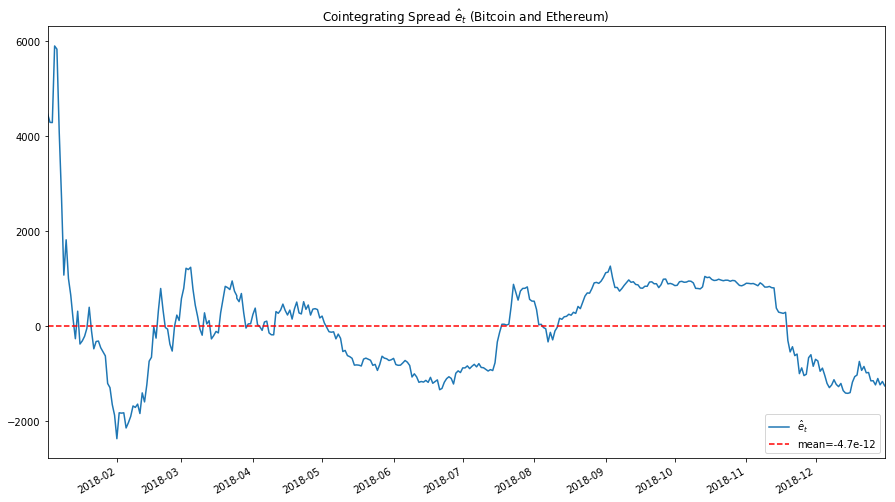

In [48]:
plt.figure(1, figsize=(15,20))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.5, 0.5])

et_hat_series = pd.Series(et_hat, name = 'Spread')

plt.subplot(gs[0])
plt.title('Cointegrating Spread $\hat{e}_t$ (Bitcoin and Ethereum)')
et_hat_series.plot()
plt.axhline(et_hat_series.mean(), color='red', linestyle='--')
plt.legend(['$\hat{e}_t$', 'mean={0:0.2g}'.format(et_hat_series.mean())], loc='lower right')
plt.xlabel('')

mu={-0.000000}, sigma={1056.306290}


Text(0, 0.5, 'Frequency')

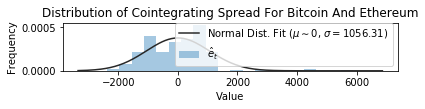

In [49]:
# Spread Histogram

plt.subplot(gs[1])

from scipy import stats

ax = sns.distplot(et_hat_series, bins=20, kde=False, fit=stats.norm)
plt.title('Distribution of Cointegrating Spread For Bitcoin And Ethereum')

# Get the fitted parameters used by Seaborn
(mu, sigma) = stats.norm.fit(et_hat_series)
print ('mu={%f}, sigma={%f}' % (mu, sigma))

# Legend and Labels

plt.legend(["Normal Dist. Fit ($\mu \sim${0}, $\sigma=${1:.2f})".format(0, sigma),'$\hat{e}_t$'])
plt.xlabel('Value')
plt.ylabel('Frequency')


Text(0, 0.5, 'PACF')

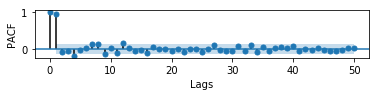

In [50]:

from statsmodels.graphics.tsaplots import plot_pacf

ax = plt.subplot(gs[2])
plot_pacf(et_hat_series, lags=50, alpha=0.01, ax=ax)
plt.title('')
plt.xlabel('Lags')
plt.ylabel('PACF')

In [120]:
from statsmodels.tsa.ar_model import AR

resultGetVectorAR = GetVectorAR(et_hat[None,:], maxlags=1, trend='c')
resultGetAR = AR(et_hat).fit(maxlag=3, trend='c', method='cmle')
print('Is AR({%d}) model stable: {%s}' % (resultGetAR.k_ar, str(IsStable(resultGetAR.roots))))
print('Is VectorAR({%s}) model stable: {%s}' % (resultGetVectorAR['maxlags'], str(IsStable(resultGetVectorAR['roots']))))
print('NOTE THAT VECTOR_AR[1] IS *NOT* STABLE')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Is AR({3}) model stable: {True}
Is VectorAR({1}) model stable: {False}
NOTE THAT VECTOR_AR[1] IS *NOT* STABLE


In [121]:
tau = 1.0 / 252.0
print(resultGetVectorAR['sigma_hat'][0])
C = resultGetVectorAR['beta_hat'][0][0]
B = resultGetVectorAR['beta_hat'][0][1]
theta = - np.log(B) / tau
mu_e = C / (1.0 - B)
sigma_ou = np.sqrt((2 * theta / 1 - np.exp(-2 * theta * tau))) * resultGetVectorAR['sigma_hat'][0]
sigma_e = sigma_ou / np.sqrt(2 * theta)
halflife = np.log(2) / theta

[62731.84181972]


In [122]:
print(' AR({%f}): C={%f}, B={%f}, tau={%f}, theta={%f}, mu_e={%f}, sigma_ou={%f}, sigma_e={%f}, halflife={%f}' % (resultGetVectorAR['maxlags'], C, B, tau, theta, mu_e, sigma_ou, sigma_e, halflife))

 AR({1.000000}): C={-15.573028}, B={0.947884}, tau={0.003968}, theta={13.487804}, mu_e={-298.815344}, sigma_ou={320344.949848}, sigma_e={61678.281021}, halflife={0.051391}


In [123]:
# AR(3)

sm_C = resultGetAR.params[0]
sm_B = resultGetAR.params[1]
sm_theta = - np.log(sm_B) / tau
sm_mu_e = sm_C / (1. - sm_B)
sm_sigma_ou = np.sqrt((2 * sm_theta / (1 - np.exp(-2 * sm_theta * tau))) * resultGetAR.sigma2)
sm_sigma_e = sm_sigma_ou / np.sqrt(2 * abs(sm_theta))
sm_halflife = np.log(2) / sm_theta
print('SM AR({%f}): sm_C={%f}, sm_B={%f}, tau={%f}, sm_theta={%f}, sm_mu_e={%f}, sm_sigma_ou={%f}, sm_sigma_e={%f}, sm_halflife={%f}' % (resultGetAR.k_ar, sm_C, sm_B, tau, sm_theta, sm_mu_e, sm_sigma_ou, sm_sigma_e, sm_halflife))

SM AR({3.000000}): sm_C={-13.699710}, sm_B={1.082076}, tau={0.003968}, sm_theta={-19.878132}, sm_mu_e={166.914802}, sm_sigma_ou={3777.673251}, sm_sigma_e={599.130747}, sm_halflife={-0.034870}


In [124]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

Y_e = et_hat_series.diff()[1:]
X_e = et_hat_series.shift(1)[1:]
X_e = add_constant(X_e)
ols = OLS(Y_e, X_e).fit()
X_e = X_e.iloc[:, 1]

ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.043    
Dependent Variable: Spread           AIC:                5044.0740
Date:               2019-07-18 13:29 BIC:                5051.8629
No. Observations:   363              Log-Likelihood:     -2520.0  
Df Model:           1                F-statistic:        17.42    
Df Residuals:       361              Prob (F-statistic): 3.76e-05 
R-squared:          0.046            Scale:              63079.   
--------------------------------------------------------------------
          Coef.     Std.Err.      t      P>|t|     [0.025     0.975]
--------------------------------------------------------------------
const    -15.5730    13.1823   -1.1814   0.2382   -41.4969   10.3508
Spread    -0.0521     0.0125   -4.1736   0.0000    -0.0767   -0.0276
------------------------------------------------------------------
Omnibus:             93.790       Durbin-Watson:          1.715   
Prob(Omnibus):       0.000        Jarque-Bera (JB):       3226.900
Skew:                -0.152       Prob(JB):               0.000   
Kurtosis:            17.603       Condition No.:          1056    
==================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

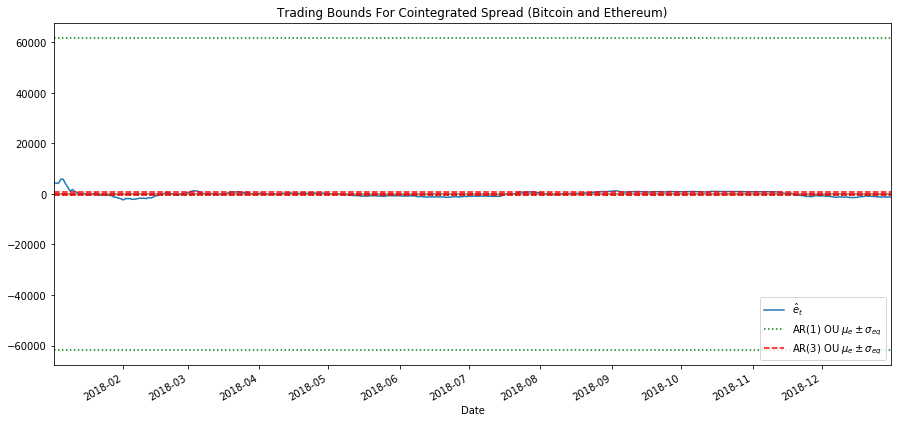

In [129]:
et_hat_series.plot(label='$\hat{e}_t$', figsize=(15, 7))

plt.title('Trading Bounds For Cointegrated Spread (Bitcoin and Ethereum)')
plt.axhline(0, color='grey', linestyle='-') # axis line
plt.axhline(mu_e, color='green', linestyle=':', label='AR(1) OU $\mu_e \pm \sigma_{eq}$')
plt.axhline(sm_mu_e, color='red', linestyle='--', label='AR(3) OU $\mu_e \pm \sigma_{eq}$')
plt.axhline(sigma_e, color='green', linestyle=':')
plt.axhline(-sigma_e, color='green', linestyle=':')
plt.axhline(sm_sigma_e, color='red', linestyle='--')
plt.axhline(-sm_sigma_e, color='red', linestyle='--')
plt.legend(loc='lower right')

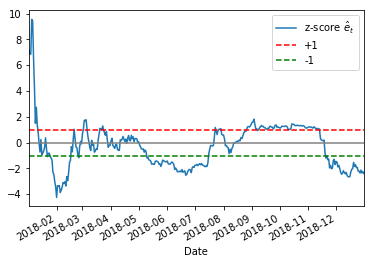

In [133]:
et_hat_n = GetZScore(et_hat, mean=sm_mu_e, sigma=sm_sigma_e)
et_hat_n_series = pd.Series(et_hat_n, name='et_hat_n')
et_hat_n_series.plot()
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['z-score $\hat{e}_t$', '+1', '-1'], loc='upper right')
plt.axhline(0, color='grey')

In [134]:
pnl_is = Get_Pnl_DF(et_hat_series, mean=sm_mu_e, sigma=sm_sigma_e)
pnl_is.tail()

,e_t_hat,e_t_hat_norm,pos,chg,pnl,pnl_cum
Date,,,,,,
2018-12-27,-1243.827480,-2.354648,1.0,134.746562,134.746562,11832.435056
2018-12-28,-1109.080918,-2.129745,1.0,-133.161373,-133.161373,11699.273683
2018-12-29,-1242.242291,-2.352003,1.0,69.897207,69.897207,11769.170891
2018-12-30,-1172.345084,-2.235338,1.0,-91.911607,-91.911607,11677.259283
2018-12-31,-1264.256691,-2.388747,1.0,NaN,NaN,NaN


In [135]:
pnl_is.loc[pnl_is['pnl'].isnull(), 'pnl']

Date
2018-12-31   NaN
Name: pnl, dtype: float64

In [140]:
%run getpyfolio.py
# Not running properly for me on this machine because I need C++ build tools to get NumPy/Lapack going - can someone else give this a run?

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


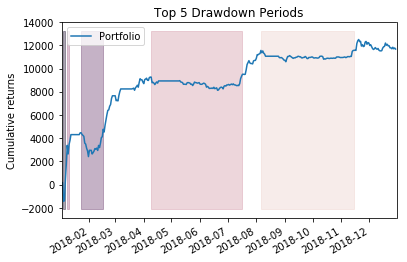

In [141]:
plot_drawdown_periods(pnl_is['pnl'], top=5)

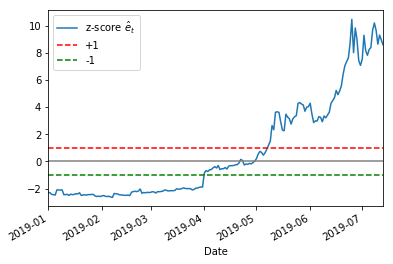

In [145]:
# OUT OF SAMPLE TESTING

# Construct the out-of-sample spread

et_hat_os = Y1_t_os - np.dot(beta2_hat, Y2_t_os) - a_hat

# Normalise to OU bounds
et_hat_os_norm = GetZScore(et_hat_os, mean=sm_mu_e, sigma=sm_sigma_e)

et_hat_os_norm = pd.Series(et_hat_os_norm, name = 'et_hat_os_norm')
et_hat_os_norm.plot()

plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['z-score $\hat{e}_t$', '+1', '-1'], loc='upper left')
plt.axhline(0, color='grey')

In [147]:
pnl_os = Get_Pnl_DF(et_hat_os, mean=sm_mu_e, sigma=sm_sigma_e)
pnl_os.tail()

,e_t_hat,e_t_hat_norm,pos,chg,pnl,pnl_cum
Date,,,,,,
2019-07-08,6289.449486,10.219029,-1.0,-328.168765,328.168765,-3667.577872
2019-07-09,5961.280722,9.671288,-1.0,-610.244477,610.244477,-3057.333395
2019-07-10,5351.036244,8.652738,-1.0,404.527622,-404.527622,-3461.861016
2019-07-11,5755.563866,9.327929,-1.0,-433.033815,433.033815,-3028.827201
2019-07-13,5322.530050,8.605159,-1.0,NaN,NaN,NaN


In [148]:
pnl_is[:-1]['pnl_cum'][-1]

11677.259283369014

In [149]:
%run getpyfolio.py

In [150]:
pnl_is.index[-1]

Timestamp('2018-12-31 00:00:00')

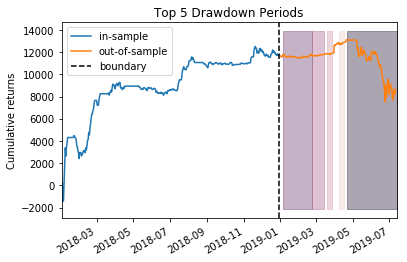

In [152]:
df_temp = pnl_is[:-1]['pnl_cum']
k = df_temp[-1]
df_temp.plot()
plot_drawdown_periods(pnl_os['pnl'], k=k, top=5)
plt.axvline(df_temp.index[-1], color='black', linestyle='--')
plt.legend(['in-sample', 'out-of-sample', 'boundary'], loc='upper left')